# problem 2: Predicting future Targeted Regions

In [126]:
import sklearn
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")
print(sklearn.__version__)  # This will print the version of scikit-learn installed


1.6.1


## Initial mode using Random Forest

C:\Users\sonny bell\AppData\Local\Temp\ipykernel_24964\1869878004.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')


Classes after grouping rare ones:
future_target
Odesa oblast                                170
Kherson oblast                              154
Mykolaiv oblast                             102
Other                                        90
Kharkiv oblast                               68
Dnipropetrovsk oblast                        45
Dnipropetrovsk oblast, Dnipro Raion          34
Dnipropetrovsk oblast, Kryvyi Rih Raion      26
Zaporizhzhia oblast                          24
Kyiv oblast                                  22
Donetsk oblast                               20
Sumy oblast                                  17
Poltava oblast                               16
Odesa oblast and Mykolaiv oblast             16
Kryvyi Rih                                   12
Dnipro                                       11
Mykolaiv oblast and Kherson oblast           10
Dnipropetrovsk oblast, Synelnykove Raion     10
Chernihiv oblast                              7
Khmelnytskyi oblast                     

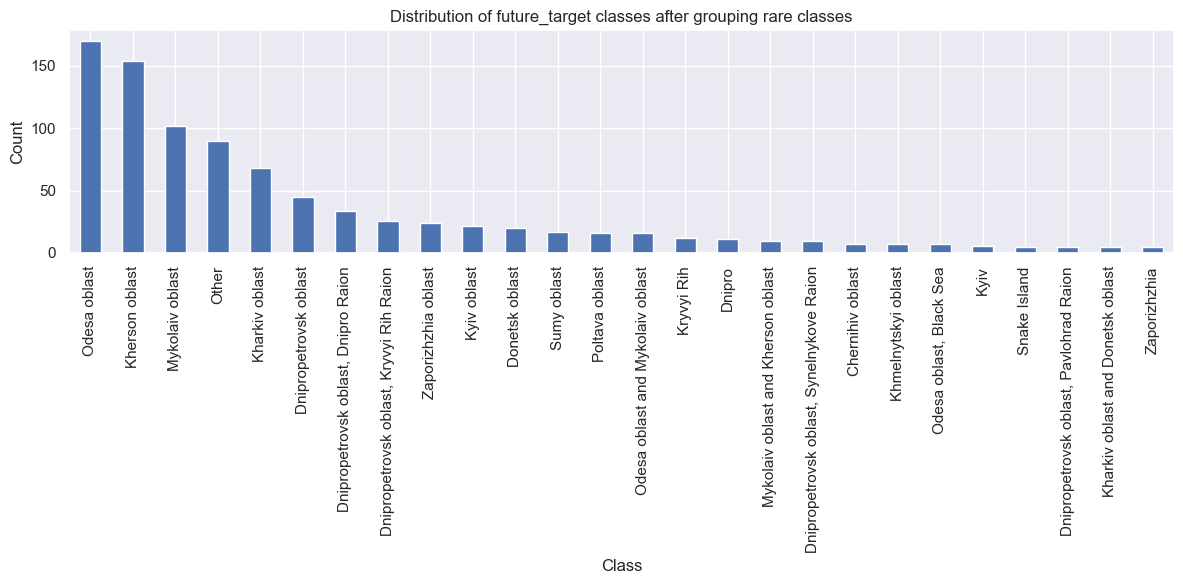

Model accuracy: 0.26


In [127]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("model2_dataset.csv")

# Convert time_start to datetime
df['time_start'] = pd.to_datetime(df['time_start'])

# Fill missing 'target' using forward/backward fill, ordered by time
df = df.sort_values(by='time_start')
df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')

# Sort by target_filled and time for proper lag creation
df = df.sort_values(by=['target_filled', 'time_start'])

# Add lag features based on target_filled
df['launched_lag1'] = df.groupby('target_filled')['launched'].shift(1).fillna(0)
df['destroyed_lag1'] = df.groupby('target_filled')['destroyed'].shift(1).fillna(0)
df['launched_lag2'] = df.groupby('target_filled')['launched'].shift(2).fillna(0)
df['destroyed_lag2'] = df.groupby('target_filled')['destroyed'].shift(2).fillna(0)

# Extract time-based features
df['year'] = df['time_start'].dt.year
df['month'] = df['time_start'].dt.month
df['day'] = df['time_start'].dt.day
df['hour'] = df['time_start'].dt.hour

# Encode target_filled as numerical feature
df['target_filled_encoded'] = OrdinalEncoder().fit_transform(df[['target_filled']])

# Drop original datetime column
df = df.drop(columns=['time_start'])

# Define features
X = df[['year', 'month', 'day', 'hour', 'launched', 'destroyed',
        'launched_lag1', 'destroyed_lag1', 'launched_lag2', 'destroyed_lag2',
        'target_filled_encoded']]

# Define target variable
y = df['future_target']

# Drop rows with missing target
mask = y.notnull()
X = X[mask]
y = y[mask]

# Group rare classes into "Other"
min_count = 5
value_counts = y.value_counts()
rare_classes = value_counts[value_counts < min_count].index
y_grouped = y.copy()
y_grouped[y_grouped.isin(rare_classes)] = "Other"

print(f"Classes after grouping rare ones:\n{y_grouped.value_counts()}\n")

# Encode the grouped target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_grouped)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on missing future_target
X_missing = df.loc[df['future_target'].isnull(), X.columns]
if not X_missing.empty:
    y_missing_pred = rf.predict(X_missing)
    predicted_labels = le.inverse_transform(y_missing_pred)
    print("Predictions for missing future_target rows:")
    print(predicted_labels)
else:
    print("No missing future_target rows to predict.")

# Visualize class distribution
plt.figure(figsize=(12,6))
pd.Series(y_grouped).value_counts().plot(kind='bar')
plt.title("Distribution of future_target classes after grouping rare classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Evaluate accuracy
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")


## Re training with XGBoost 

C:\Users\sonny bell\AppData\Local\Temp\ipykernel_24964\2756281104.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')
c:\Users\sonny bell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classes after grouping rare ones:
 future_target
Odesa oblast                                170
Kherson oblast                              154
Mykolaiv oblast                             102
Other                                        90
Kharkiv oblast                               68
Dnipropetrovsk oblast                        45
Dnipropetrovsk oblast, Dnipro Raion          34
Dnipropetrovsk oblast, Kryvyi Rih Raion      26
Zaporizhzhia oblast                          24
Kyiv oblast                                  22
Donetsk oblast                               20
Sumy oblast                                  17
Poltava oblast                               16
Odesa oblast and Mykolaiv oblast             16
Kryvyi Rih                                   12
Dnipro                                       11
Mykolaiv oblast and Kherson oblast           10
Dnipropetrovsk oblast, Synelnykove Raion     10
Chernihiv oblast                              7
Khmelnytskyi oblast                    

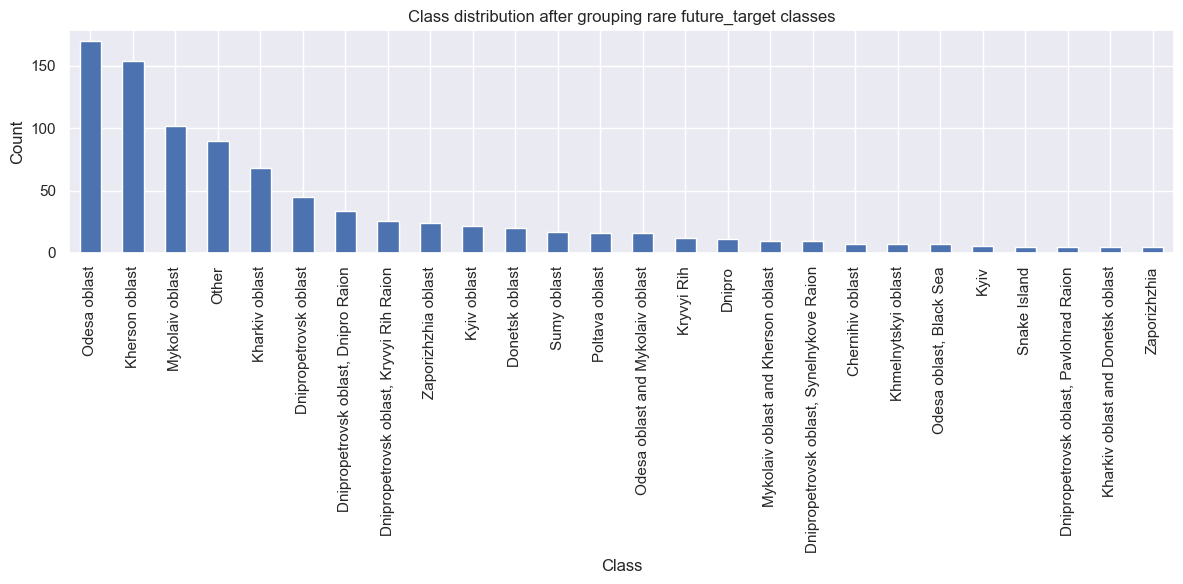

Model accuracy (Improved XGBoost): 0.27


In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load and sort
df = pd.read_csv("model2_dataset.csv")
df['time_start'] = pd.to_datetime(df['time_start'])
df = df.sort_values(by='time_start')

# Fill missing target
df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')

# Group by location for temporal features
df = df.sort_values(by=['target_filled', 'time_start'])

# Lag features
df['launched_lag1'] = df.groupby('target_filled')['launched'].shift(1).fillna(0)
df['destroyed_lag1'] = df.groupby('target_filled')['destroyed'].shift(1).fillna(0)
df['launched_lag2'] = df.groupby('target_filled')['launched'].shift(2).fillna(0)
df['destroyed_lag2'] = df.groupby('target_filled')['destroyed'].shift(2).fillna(0)

# Rolling stats (3-step mean)
df['launched_roll3'] = df.groupby('target_filled')['launched'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df['destroyed_roll3'] = df.groupby('target_filled')['destroyed'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

# Cumulative features
df['launched_cumsum'] = df.groupby('target_filled')['launched'].cumsum()
df['destroyed_cumsum'] = df.groupby('target_filled')['destroyed'].cumsum()

# Attack ratio
df['attack_ratio'] = (df['destroyed'] + 1) / (df['launched'] + 1)

# Binary attack indicator
df['had_attack'] = (df['launched'] > 0).astype(int)

# Date-based features
df['year'] = df['time_start'].dt.year
df['month'] = df['time_start'].dt.month
df['day'] = df['time_start'].dt.day
df['hour'] = df['time_start'].dt.hour
df['dayofweek'] = df['time_start'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Ordinal encoding of location
df['target_filled_encoded'] = OrdinalEncoder().fit_transform(df[['target_filled']])

# Drop datetime
df = df.drop(columns=['time_start'])

# Select features
feature_cols = [
    'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend',
    'launched', 'destroyed', 'attack_ratio', 'had_attack',
    'launched_lag1', 'destroyed_lag1', 'launched_lag2', 'destroyed_lag2',
    'launched_roll3', 'destroyed_roll3', 'launched_cumsum', 'destroyed_cumsum',
    'target_filled_encoded'
]

X = df[feature_cols]
y = df['future_target']

# Filter out null targets
mask = y.notnull()
X = X[mask]
y = y[mask]

# Group rare target labels
min_count = 5
value_counts = y.value_counts()
rare_classes = value_counts[value_counts < min_count].index
y_grouped = y.copy()
y_grouped[y_grouped.isin(rare_classes)] = "Other"

print("Classes after grouping rare ones:\n", y_grouped.value_counts(), "\n")

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y_grouped)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predict missing
X_missing = df.loc[df['future_target'].isnull(), feature_cols]
if not X_missing.empty:
    y_missing_pred = xgb.predict(X_missing)
    predicted_labels = le.inverse_transform(y_missing_pred)
    print("Predictions for missing future_target rows:\n", predicted_labels)
else:
    print("No missing future_target rows to predict.")

# Plot class distribution
plt.figure(figsize=(12, 6))
pd.Series(y_grouped).value_counts().plot(kind='bar')
plt.title("Class distribution after grouping rare future_target classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Evaluate
accuracy = xgb.score(X_test, y_test)
print(f"Model accuracy (Improved XGBoost): {accuracy:.2f}")


### Tuning the XGBoost Pipeline with optuna

[I 2025-06-17 10:59:00,881] A new study created in memory with name: no-name-3df8b2eb-8030-4601-9239-7925557cf0a1
[I 2025-06-17 10:59:03,492] Trial 0 finished with value: 0.10614525139664804 and parameters: {'n_estimators': 745, 'max_depth': 4, 'learning_rate': 0.026401965643680123, 'subsample': 0.5014531301668353, 'colsample_bytree': 0.9522239614547214, 'gamma': 8.000893830882777, 'reg_alpha': 6.345913502433245, 'reg_lambda': 8.637920028288825}. Best is trial 0 with value: 0.10614525139664804.
[I 2025-06-17 10:59:04,638] Trial 1 finished with value: 0.19553072625698323 and parameters: {'n_estimators': 275, 'max_depth': 3, 'learning_rate': 0.050281192025417844, 'subsample': 0.9495947144258146, 'colsample_bytree': 0.4245676692942256, 'gamma': 7.985794371672292, 'reg_alpha': 2.0106638760970363, 'reg_lambda': 2.235031932034582}. Best is trial 1 with value: 0.19553072625698323.
[I 2025-06-17 10:59:06,938] Trial 2 finished with value: 0.2681564245810056 and parameters: {'n_estimators': 678,

Best trial:
  Value (accuracy): 0.29608938547486036
  Params: {'n_estimators': 970, 'max_depth': 15, 'learning_rate': 0.1986691555216862, 'subsample': 0.5081731765004311, 'colsample_bytree': 0.548976779830597, 'gamma': 0.9649008113546597, 'reg_alpha': 5.638346178928046, 'reg_lambda': 4.027915113501027}
Predictions for missing future_target rows:
 ['Other' 'Dnipro' 'Other' 'Dnipro' 'Dnipro' 'Dnipro' 'Donetsk oblast'
 'Dnipro' 'Dnipro' 'Dnipro' 'Dnipro' 'Dnipro' 'Dnipro' 'Dnipro' 'Dnipro'
 'Dnipro' 'Dnipro' 'Donetsk oblast' 'Dnipro' 'Dnipro' 'Dnipro' 'Dnipro'
 'Donetsk oblast' 'Dnipropetrovsk oblast' 'Donetsk oblast'
 'Khmelnytskyi oblast' 'Kryvyi Rih' 'Dnipro' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast'
 'Snake Island' 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk oblast' 'Kryvyi Rih' 'Kryvyi Rih' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk oblast

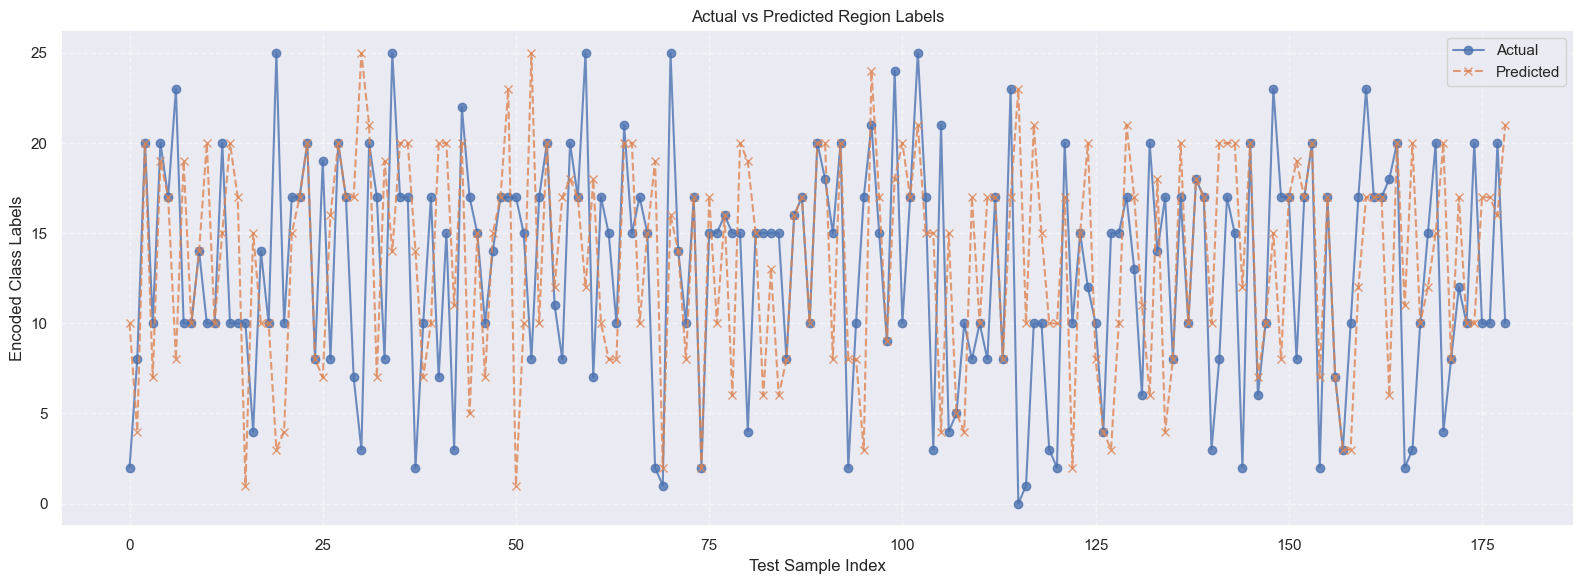

C:\Users\sonny bell\AppData\Local\Temp\ipykernel_24964\1768574148.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_mis_df, x="Count", y="Misclassification", palette="Reds_r")
C:\Users\sonny bell\AppData\Local\Temp\ipykernel_24964\1768574148.py:106: UserWarning: Glyph 10141 (\N{TRIANGLE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sonny bell\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10141 (\N{TRIANGLE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


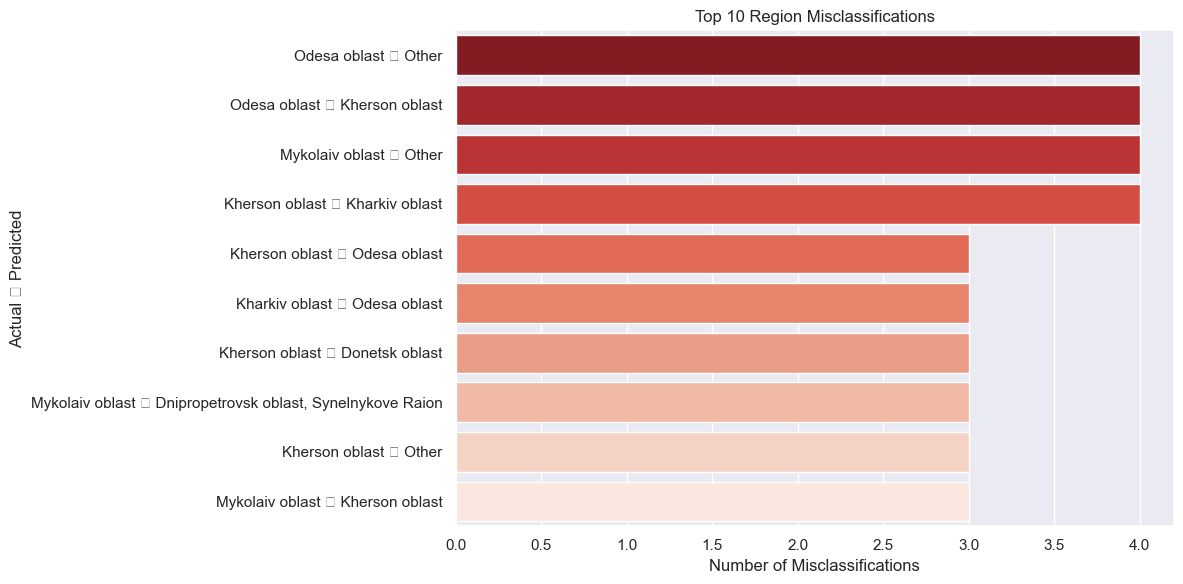

In [ ]:
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 1. opuna tuning (with SMOTE)
def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),  # increased upper bound
    "max_depth": trial.suggest_int("max_depth", 3, 15),            # deeper trees allowed
    "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),  # finer granularity
    "subsample": trial.suggest_float("subsample", 0.3, 1.0),       # allow smaller subsets
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),  # more feature subsampling
    "gamma": trial.suggest_float("gamma", 0, 10),                  # wider regularization
    "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),      # increased L1 regularization range
    "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),    # increased L2 regularization range
    "eval_metric": "mlogloss",
    "random_state": 42
}


    # Dynamically determine safe k_neighbors for SMOTE
    min_class_size = min(Counter(y_train).values())
    safe_k = max(1, min(min_class_size - 1, 5))

    sm = SMOTE(k_neighbors=safe_k, random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    model = XGBClassifier(**params)
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=3600)


print("Best trial:")
print(f"  Value (accuracy): {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

# 2. FINAL MODEL TRAINING WITH BEST PARAMS + SMOTE
best_params = study.best_trial.params
best_params.update({
    "eval_metric": "mlogloss",
    "random_state": 42
})

# Use same safe SMOTE strategy
min_class_size = min(Counter(y_train).values())
safe_k = max(1, min(min_class_size - 1, 5))
sm = SMOTE(k_neighbors=safe_k, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_resampled, y_resampled)

# 3. MISSING PREDICTIONS
if not X_missing.empty:
    y_missing_pred = xgb_best.predict(X_missing)
    predicted_labels = le.inverse_transform(y_missing_pred)
    print("Predictions for missing future_target rows:\n", predicted_labels)

# 4. EVALUATE FINAL MODEL
y_pred = xgb_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Tuned XGBoost Accuracy (with SMOTE): {accuracy:.2f}")

# 5. PLOT ACTUAL vs PREDICTED (CATEGORICAL)
plt.figure(figsize=(16, 6))
plt.plot(y_test, label='Actual', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred, label='Predicted', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Region Labels')
plt.xlabel('Test Sample Index')
plt.ylabel('Encoded Class Labels')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6. TOP 10 MISCLASSIFICATIONS
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_no_diag = cm_df.astype(float).copy()
np.fill_diagonal(cm_no_diag.values, np.nan)

misclassified_pairs = cm_no_diag.unstack().dropna().sort_values(ascending=False)
top_n = 10
top_mis_df = misclassified_pairs.head(top_n).rename_axis(['Predicted', 'Actual']).reset_index(name='Count')
top_mis_df["Misclassification"] = top_mis_df["Actual"] + " ➝ " + top_mis_df["Predicted"]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_mis_df, x="Count", y="Misclassification", palette="Reds_r")
plt.title(f"Top {top_n} Region Misclassifications")
plt.xlabel("Number of Misclassifications")
plt.ylabel("Actual ➝ Predicted")
plt.tight_layout()
plt.show()


## Trying the same pipeline in LGBM (Light Gradient Boosting Machine)

In [141]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("model2_dataset.csv")

# Convert time_start to datetime and sort for lag features
df['time_start'] = pd.to_datetime(df['time_start'])
df = df.sort_values(by=['target', 'time_start'])

# Fill missing 'target' with a placeholder for lag grouping
df['target_filled'] = df['target'].fillna('Unknown')

# Add lag features
df['launched_lag1'] = df.groupby('target_filled')['launched'].shift(1).fillna(0)
df['destroyed_lag1'] = df.groupby('target_filled')['destroyed'].shift(1).fillna(0)
df['launched_lag2'] = df.groupby('target_filled')['launched'].shift(2).fillna(0)
df['destroyed_lag2'] = df.groupby('target_filled')['destroyed'].shift(2).fillna(0)

# Add additional features
df['year'] = df['time_start'].dt.year
df['month'] = df['time_start'].dt.month
df['day'] = df['time_start'].dt.day
df['hour'] = df['time_start'].dt.hour
df['weekday'] = df['time_start'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['efficiency'] = df['destroyed'] / (df['launched'] + 1e-3)
df['efficiency'] = df['efficiency'].fillna(0).clip(0, 1)

# Drop the datetime column and target_filled (used only for grouping)
df = df.drop(columns=['time_start', 'target_filled'])

# Define features and target
features = ['year', 'month', 'day', 'hour', 'weekday', 'is_weekend',
            'launched', 'destroyed', 'launched_lag1', 'destroyed_lag1',
            'launched_lag2', 'destroyed_lag2', 'efficiency']

X = df[features]
y = df['future_target']

# Drop rows with missing target
mask = y.notnull()
X = X[mask]
y = y[mask]

# Group rare target classes into "Other"
min_count = 5
value_counts = y.value_counts()
rare_classes = value_counts[value_counts < min_count].index
y_grouped = y.copy()
y_grouped[y_grouped.isin(rare_classes)] = "Other"

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_grouped)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train LightGBM
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Evaluate
accuracy = lgbm.score(X_test, y_test)
accuracy


0.22905027932960895